<a href="https://colab.research.google.com/github/technologyhamed/Apache-PySpark/blob/main/RFM_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

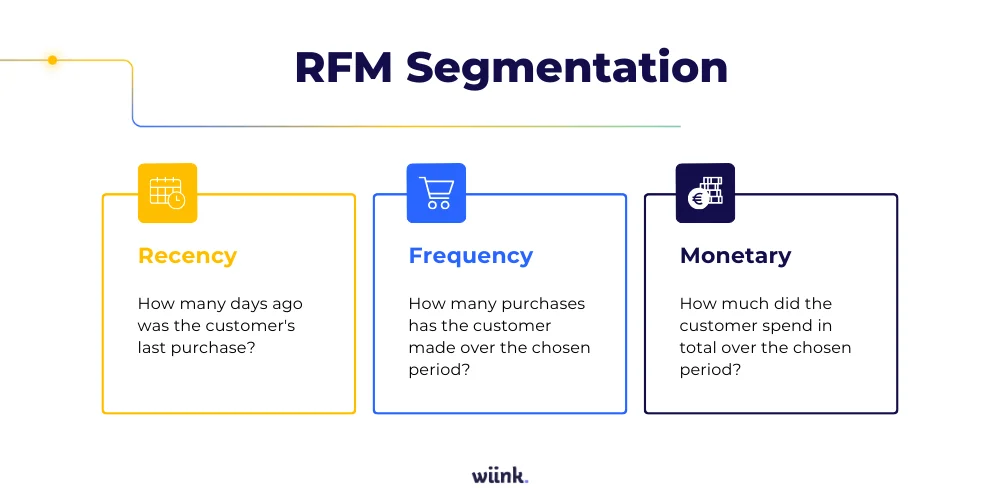

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'onlineretail:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3466%2F5596%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240820%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240820T171538Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D67dec48420433cb13eb0679c06763815511f86d12a05670491b8620ad8d288819279cdab4f058c79a32991b14fc5bb267be3e0ec6c0f6575b7e1a3b23bca93a0dc0e2fededa2f61fd025cd583b6c5b7e4ee5ffac6a92f4e35f84a029219a90ad598685ec495f5c3025894b0441ff009443cb1449b406d8eca68717b03b6c847fdf52692dbfcd151a3fae2493273c3e41ac84e7663a2f0cd5a1c91e323119611eb5633fea055af6938c74d38fa47f0c66397ea7a0565c531083069f4604fe8b4b05752185ba897f4f5ac3bf8f37895ff99fa15f418bb5703f6536c65038afa94676946365eee80ca6a8a08084aac5da9a509e41f7974621426025e81adef6b11f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


[==================================================] 7548702 bytes downloaded
Downloaded and uncompressed: onlineretail
Data source import complete.


In [2]:
!pip install pyspark
!pip install jdatetime

****RFM Analysis****

The above figure source: Blast Analytics Marketing

RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries. More details can be found at Wikipedia RFM_wikipedia.

RFM stands for the three dimensions:

Recency – How recently did the customer purchase? i.e. Duration since last purchase

Frequency – How often do they purchase? i.e. Total number of purchases

Monetary Value – How much do they spend? i.e. Total money this customer spent

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark RFM example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [5]:
df_raw = spark.read.format('com.databricks.spark.csv').\
                       options(header='true', \
                       inferschema='true').\
            load("/kaggle/input/onlineretail/OnlineRetail.csv",header=True);

In [6]:
#df_raw.show(5)
df_raw.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



**Data clean and data manipulation**

check and remove the null values

In [7]:
from pyspark.sql.functions import count

def my_count(df_in):
    df_in.agg( *[ count(c).alias(c) for c in df_in.columns ] ).show()

In [8]:
my_count(df_raw)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   541909|   541909|     540455|  541909|     541909|   541909|    406829| 541909|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



**Since the count results are not the same, we have some null value in the CustomerID column. We can drop these records from the dataset.**

In [15]:
df = df_raw.dropna(how='any')
my_count(df)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   406829|   406829|     406829|  406829|     406829|   406829|    406829| 406829|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import jdatetime
import datetime  # Import the datetime module

# Define a UDF to convert a datetime string to a Persian datetime
@udf(StringType())
def convert_to_persian_datetime(datetime_str):
    try:
        # Parse the datetime string to a Python datetime object
        dt = datetime.datetime.strptime(datetime_str, "%Y-%m-%d")

        # Convert the Python datetime object to a Persian datetime object
        persian_dt = jdatetime.datetime(dt.year, dt.month, dt.day)

        # Format the Persian datetime object as a string
        persian_datetime_str = persian_dt.strftime("%Y/%m/%d")

        return persian_datetime_str
    except ValueError:
        return None

# Create a DataFrame with a datetime string column
df = spark.createDataFrame([("2024-08-20",)], ["datetime_str"])

# Apply the UDF to convert the datetime string to a Persian datetime
df_with_persian_datetime = df.withColumn("persian_datetime", convert_to_persian_datetime("datetime_str"))

# Show the result
df_with_persian_datetime.show()

+------------+----------------+
|datetime_str|persian_datetime|
+------------+----------------+
|  2024-08-20|      2024/08/20|
+------------+----------------+



In [16]:
from pyspark.sql.functions import unix_timestamp, to_utc_timestamp, col

timeFmt = "MM/dd/yy HH:mm"

df = df.withColumn('NewInvoiceDate'
                 , to_utc_timestamp(unix_timestamp(col('InvoiceDate'),timeFmt).cast('timestamp'),'UTC'))

**The spark is pretty sensitive to the date format!**

> **calculate total price**

In [17]:
from pyspark.sql.functions import round

df = df.withColumn('TotalPrice', round( df.Quantity * df.UnitPrice, 2 ) )

In [19]:
from pyspark.sql.functions import mean, min, max, sum, datediff, to_date, lit, unix_timestamp, to_utc_timestamp

# Set legacy time parser policy for compatibility
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

date_max = df.select(max('NewInvoiceDate')).toPandas()
current = to_utc_timestamp(unix_timestamp(lit(str(date_max.iloc[0][0])), \
                              'yy-MM-dd HH:mm').cast('timestamp'), 'UTC' )

# Calculatre Duration
df = df.withColumn('Duration', datediff(lit(current), 'NewInvoiceDate'))
df.show(5)

<ipython-input-19-51dfabd6cb79>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current = to_utc_timestamp(unix_timestamp(lit(str(date_max.iloc[0][0])), \


+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+----------+--------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|     NewInvoiceDate|TotalPrice|Duration|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+----------+--------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|2010-12-01 08:26:00|      15.3|     373|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|     20.34|     373|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|2010-12-01 08:26:00|      22.0|     373|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|     20.34|     373|

In [21]:
recency = df.groupBy('CustomerID').agg(min('Duration').alias('Recency'))
frequency = df.groupBy('CustomerID', 'InvoiceNo').count()\
                        .groupBy('CustomerID')\
                        .agg(count("*").alias("Frequency"))
monetary = df.groupBy('CustomerID').agg(round(sum('TotalPrice'), 2).alias('Monetary'))
rfm = recency.join(frequency,'CustomerID', how = 'inner')\
             .join(monetary,'CustomerID', how = 'inner')

In [22]:
rfm.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     17389|      0|       43|31300.08|
|     13623|     30|        7|  672.44|
|     14450|    180|        3|  483.25|
|     15727|     16|        7| 5178.96|
|     13285|     23|        4| 2709.12|
+----------+-------+---------+--------+
only showing top 5 rows



**13.2.2. RFM Segmentation**

> Determine cutting points
In this section, you can use the techniques (statistical results and visualizations) in Data Exploration section to help you determine the cutting points for each attribute. In my opinion, the cutting points are mainly depend on the business sense. You’s better talk to your makrting people and get feedback and suggestion from them. I will use the quantile as the cutting points in this demo.

In [23]:
import pandas as pd

def describe_pd(spark_df, cols, decimals):
    """
    Calculates descriptive statistics for specified columns in a PySpark DataFrame
    and displays them in a pandas-like format.

    Args:
        spark_df: The PySpark DataFrame.
        cols: A list of column names to calculate statistics for.
        decimals: Number of decimal places to round to.
    """
    summary = spark_df.select(cols).summary()
    pandas_df = summary.toPandas().set_index("summary")
    pandas_df = pandas_df.round(decimals)
    display(pandas_df)

cols = ['Recency','Frequency','Monetary']
describe_pd(rfm, cols, 1)

,Recency,Frequency,Monetary
summary,,,
count,4372,4372,4372
mean,91.58119853613907,5.07548032936871,1898.4597003659621
stddev,100.77213931384827,9.33875416357473,8219.34514113974
min,0,1,-4287.63
25%,16,1,293.1
50%,50,3,647.74
75%,143,5,1611.59
max,373,248,279489.02


The user defined function by using the cutting points:

In [24]:
def RScore(x):
    if  x <= 16:
        return 1
    elif x<= 50:
        return 2
    elif x<= 143:
        return 3
    else:
        return 4

def FScore(x):
    if  x <= 1:
        return 4
    elif x <= 3:
        return 3
    elif x <= 5:
        return 2
    else:
        return 1

def MScore(x):
    if  x <= 293:
        return 4
    elif x <= 648:
        return 3
    elif x <= 1611:
        return 2
    else:
        return 1




In [26]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

R_udf = udf(lambda x: RScore(x), StringType())
F_udf = udf(lambda x: FScore(x), StringType())
M_udf = udf(lambda x: MScore(x), StringType())

****RFM Segmentation****

In [27]:
rfm_seg = rfm.withColumn("r_seg", R_udf("Recency"))
rfm_seg = rfm_seg.withColumn("f_seg", F_udf("Frequency"))
rfm_seg = rfm_seg.withColumn("m_seg", M_udf("Monetary"))
rfm_seg.show(5)

+----------+-------+---------+--------+-----+-----+-----+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|
+----------+-------+---------+--------+-----+-----+-----+
|     17389|      0|       43|31300.08|    1|    1|    1|
|     13623|     30|        7|  672.44|    2|    1|    2|
|     14450|    180|        3|  483.25|    4|    3|    3|
|     15727|     16|        7| 5178.96|    1|    1|    1|
|     13285|     23|        4| 2709.12|    2|    2|    1|
+----------+-------+---------+--------+-----+-----+-----+
only showing top 5 rows



In [28]:
from pyspark.sql.functions import udf, concat, col
from pyspark.sql.types import StringType, DoubleType

# ... (rest of your code)

rfm_seg = rfm_seg.withColumn('RFMScore',
                             concat(col('r_seg'),col('f_seg'), col('m_seg'))) # Use concat and col from pyspark.sql.functions
rfm_seg.sort(col('RFMScore')).show(5)

+----------+-------+---------+--------+-----+-----+-----+--------+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|RFMScore|
+----------+-------+---------+--------+-----+-----+-----+--------+
|     18161|     10|        6| 1612.79|    1|    1|    1|     111|
|     12471|      2|       49|18740.92|    1|    1|    1|     111|
|     17389|      0|       43|31300.08|    1|    1|    1|     111|
|     15727|     16|        7| 5178.96|    1|    1|    1|     111|
|     17754|      0|        6| 1739.92|    1|    1|    1|     111|
+----------+-------+---------+--------+-----+-----+-----+--------+
only showing top 5 rows



**13.2.3. Statistical Summary**

simple summary

In [29]:
import pyspark.sql.functions as F  # Import and alias pyspark.sql.functions as F

rfm_seg.groupBy('RFMScore')\
    .agg({'Recency':'mean',
          'Frequency': 'mean',
          'Monetary': 'mean'} )\
    .sort(F.col('RFMScore')).show(5)  # Now you can use F.col

+--------+-----------------+------------------+------------------+
|RFMScore|     avg(Recency)|     avg(Monetary)|    avg(Frequency)|
+--------+-----------------+------------------+------------------+
|     111|6.035123966942149| 8828.888595041319|18.882231404958677|
|     112|7.237113402061856|1223.3604123711339| 7.752577319587629|
|     113|              8.0|          505.9775|               7.5|
|     114|             11.0|            191.17|               8.0|
|     121|6.472727272727273|2569.0619999999994| 4.636363636363637|
+--------+-----------------+------------------+------------------+
only showing top 5 rows



**Complex summery**

In [35]:
import pyspark.sql.functions as F

def quantile_agg(df_input, grp, num_cols):
    # Implement your quantile aggregation logic here
    # For example:
    result = df_input.groupBy(grp).agg(
        *[F.percentile_approx(col, [0.25, 0.5, 0.75]).alias(col + '_quantiles') for col in num_cols]
    )
    return result

def deciles_agg(df_input, grp, num_cols):
    # Implement your deciles aggregation logic here
    # For example:
    result = df_input.groupBy(grp).agg(
        *[F.percentile_approx(col, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).alias(col + '_deciles') for col in num_cols]
    )
    return result

grp = 'RFMScore'
num_cols = ['Recency','Frequency','Monetary']
df_input = rfm_seg
outputdir='/content/sample_data/outputdir/'

quantile_grouped = quantile_agg(df_input,grp,num_cols)
quantile_grouped.toPandas().to_csv(outputdir + 'quantile_grouped.csv')

deciles_grouped = deciles_agg(df_input,grp,num_cols)
deciles_grouped.toPandas().to_csv(outputdir + 'deciles_grouped.csv')